# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
# Define transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

# Create training set and define training dataloader
training_data = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)

# Create test set and define test dataloader
test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

As the data is already B&W, no color related transformation will be useful and the data is images of numbers, rotating & inverting the data will change it to images which are not numbers. and resize will cause error in feeding it to neural network.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

In [4]:
train_loader.dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
test_loader.dataset.data.shape

torch.Size([10000, 28, 28])

1


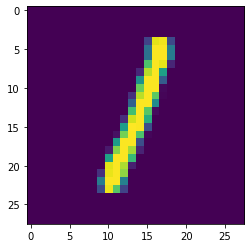

1


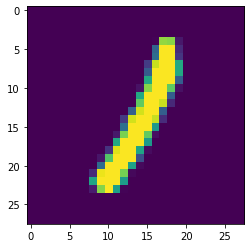

4


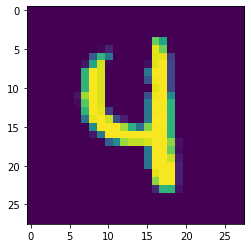

2


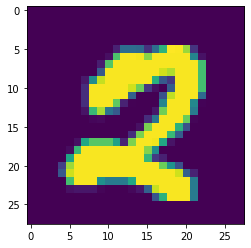

5


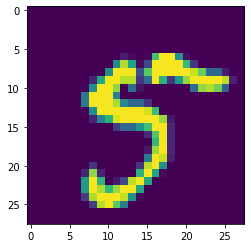

In [6]:
# Explore data

show5(train_loader)

4


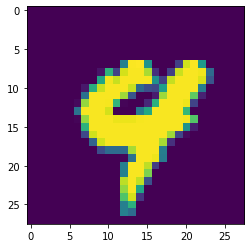

4


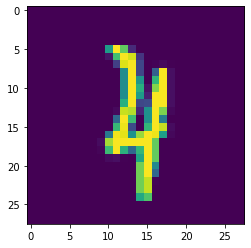

2


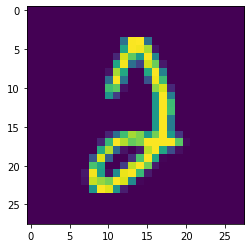

3


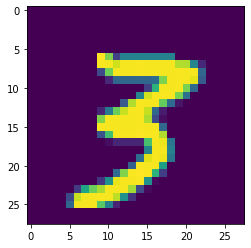

5


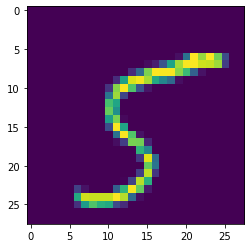

In [7]:
show5(test_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = F.log_softmax(self.fc3(x))
        return x

model = Model()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()
model.to(device)

Model(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [10]:
num_epochs = 15

train_loss_history = list()

for epoch in range(num_epochs):
    
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_loader):
        inputs, labels = data

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {100*train_correct/train_loader.dataset.data.shape[0]:.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


Epoch 1 training accuracy: 88.37% training loss: 0.39454
Epoch 2 training accuracy: 94.05% training loss: 0.19248
Epoch 3 training accuracy: 95.66% training loss: 0.14135
Epoch 4 training accuracy: 96.56% training loss: 0.11260
Epoch 5 training accuracy: 97.03% training loss: 0.09540
Epoch 6 training accuracy: 97.27% training loss: 0.08349
Epoch 7 training accuracy: 97.72% training loss: 0.07263
Epoch 8 training accuracy: 97.89% training loss: 0.06583
Epoch 9 training accuracy: 98.09% training loss: 0.05968
Epoch 10 training accuracy: 98.19% training loss: 0.05497
Epoch 11 training accuracy: 98.31% training loss: 0.05111
Epoch 12 training accuracy: 98.54% training loss: 0.04436
Epoch 13 training accuracy: 98.49% training loss: 0.04351
Epoch 14 training accuracy: 98.68% training loss: 0.04021
Epoch 15 training accuracy: 98.85% training loss: 0.03528


Plot the training loss (and validation loss/accuracy, if recorded).

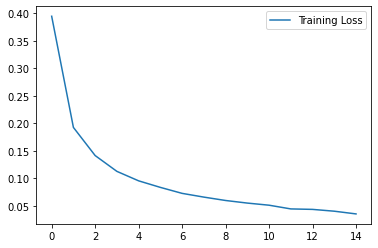

In [11]:
plt.plot(train_loss_history, label="Training Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [13]:
val_loss = 0.0
val_correct = 0
model.eval()
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs.data, 1)
    val_correct += (preds == labels).sum().item()
    val_loss += loss.item()
print(f'validation accuracy: {100*val_correct/test_loader.dataset.data.shape[0]:.2f}% validation loss: {val_loss/len(test_loader):.5f}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


validation accuracy: 97.46% validation loss: 0.09432


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [14]:
val_loss = 0.0
val_correct = 0
model.eval()
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs.data, 1)
    val_correct += (preds == labels).sum().item()
    val_loss += loss.item()
print(f'validation accuracy: {100*val_correct/test_loader.dataset.data.shape[0]:.2f}% validation loss: {val_loss/len(test_loader):.5f}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


validation accuracy: 97.46% validation loss: 0.09431


## Saving your model
Using `torch.save`, save your model for future loading.

In [15]:
torch.save(model.state_dict, 'checkpoint.pth')